In [1]:
import os
import sys

sys.path.append("/home/yuri/github.com/AoesJP/project_pokereader")
sys.path

%load_ext autoreload
%autoreload 2

In [1706]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2
import pickle
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev

In [1707]:
from pokedex.edges import deformer, draw
from pokedex import HIRES_HEIGHT, HIRES_WIDTH

In [1708]:
np.array([[1, 2, 3], [4, 2, 5], [5, 4, 2], [5, 2, 3]]) * np.array([1, -1, 0, 1]).reshape(4, 1)

array([[ 1,  2,  3],
       [-4, -2, -5],
       [ 0,  0,  0],
       [ 5,  2,  3]])

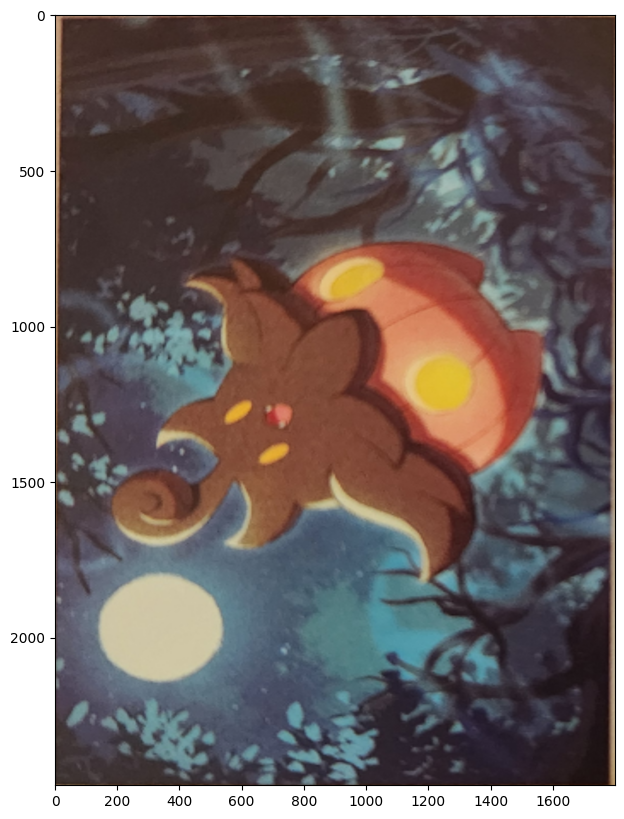

In [2172]:
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/IMG_1488.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/IMG_1498.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/swsh12pt5-62.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/dv1-2.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/charizard2.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/pika.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke1.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke2.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/home/20240523_211006.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/home/20240523_210824.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/home/20240520_122513.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/home/20240523_222811.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/home/20240523_222803.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/home/20240526_235214.jpg"
img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/home/20240526_235233.jpg"
test_img = Image.open(img_path)
# plt.imshow(np.flip(np.array(test_img).transpose(1, 0, 2), axis=1))
# plt.imshow(np.array(test_img))
# img, deformed_img = deformer.deform_card(test_img)
deformed_img = deformer.deform_card(test_img)
# deformed_img = deformer.deform_card(img_path)
# draw.show_color(test_img)
draw.show_color(deformed_img)
# draw.draw_lines(img, deformed_img)

In [2086]:
np.sign(np.array([-3.2]))

array([-1.])

In [2087]:
img_file = Image.open(img_path)
img_file = ImageOps.exif_transpose(img_file)
# img_file = cv2.imread(img_path)
converted_img = np.array(img_file)[:, :, :3]

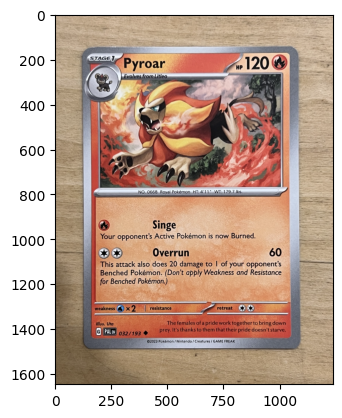

In [2088]:
plt.imshow(converted_img)

In [2089]:
converted_img.shape, converted_img.dtype

((1646, 1236, 3), dtype('uint8'))

In [2090]:
output_shape: tuple[int, int] = (HIRES_WIDTH, HIRES_HEIGHT)

In [2120]:
loaded_shape = converted_img.shape[:2]
max_length = max(loaded_shape)
MAX_EDGE_LENGTH = 1200
edge_scale_ratio = MAX_EDGE_LENGTH / max_length
IMG_SIZE = (int(loaded_shape[1] * edge_scale_ratio), int(loaded_shape[0] * edge_scale_ratio))
# img = resize_with_fill(cv2.cvtColor(np.array(img_file), cv2.COLOR_BGR2RGB), IMG_SIZE[0], IMG_SIZE[1])
# img = cv2.resize(cv2.cvtColor(converted_img, cv2.COLOR_BGR2RGB), IMG_SIZE[0], IMG_SIZE[1])
img = cv2.resize(converted_img, IMG_SIZE)
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
blur_ammount = 13
blurred_rgb = cv2.GaussianBlur(img, (blur_ammount, blur_ammount), 0)
blurred_hsv = cv2.GaussianBlur(img_hsv, (blur_ammount, blur_ammount), 0)
# morph_kernel = (7, 7)
# blurred_rgb = cv2.morphologyEx(blurred_rgb, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=morph_kernel), iterations=2)
# blurred_hsv = cv2.morphologyEx(blurred_hsv, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=morph_kernel), iterations=2)
# blurred_rgb = cv2.GaussianBlur(blurred_rgb, (blur_ammount, blur_ammount), 0)
# blurred_hsv = cv2.GaussianBlur(blurred_hsv, (blur_ammount, blur_ammount), 0)

alpha = 1.5
beta = -50
img_r = deformer.apply_contrast(blurred_rgb[:, :, 0], alpha=alpha, beta=beta)
img_g = deformer.apply_contrast(blurred_rgb[:, :, 1], alpha=alpha, beta=beta)
img_b = deformer.apply_contrast(blurred_rgb[:, :, 2], alpha=alpha, beta=beta)
img_h = deformer.apply_contrast(blurred_hsv[:, :, 0], alpha=alpha, beta=beta)
img_s = deformer.apply_contrast(blurred_hsv[:, :, 1], alpha=alpha, beta=beta)
img_v = deformer.apply_contrast(blurred_hsv[:, :, 2], alpha=alpha, beta=beta)
edge_mono = cv2.cvtColor(deformer.mono_grad(blurred_rgb, 3), cv2.COLOR_BGR2GRAY)
canney_min = 50
canney_max = 150
edger = deformer.expand_edges(cv2.Canny(img_r, canney_min, canney_max))
edgeg = deformer.expand_edges(cv2.Canny(img_g, canney_min, canney_max))
edgeb = deformer.expand_edges(cv2.Canny(img_b, canney_min, canney_max))
edge1 = deformer.expand_edges(cv2.Canny(img_h, canney_min, canney_max))
edge2 = deformer.expand_edges(cv2.Canny(img_s, canney_min, canney_max))
edge3 = deformer.expand_edges(cv2.Canny(img_v, canney_min, canney_max))
# edge_all = cv2.max(cv2.max(edge1, edge2), edge3)

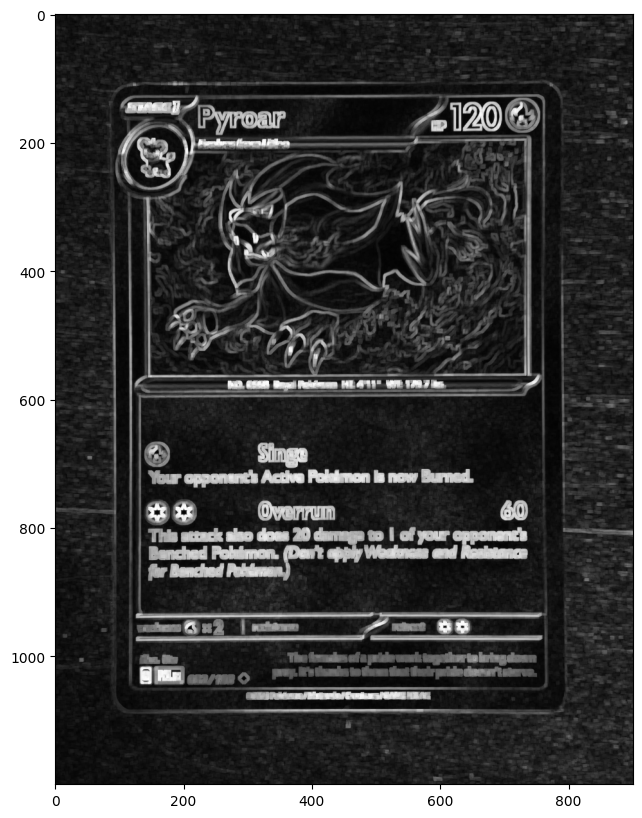

In [2121]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.morphologyEx(cv2.cvtColor(deformer.mono_grad(img, 5), cv2.COLOR_BGR2GRAY), cv2.MORPH_OPEN, (31, 31)), cmap="grey")

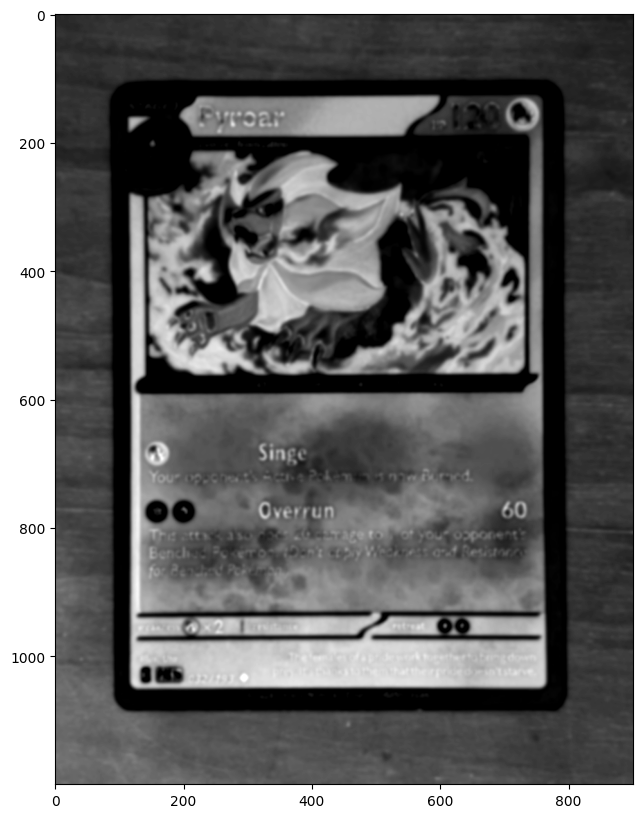

In [2122]:
plt.figure(figsize=(10, 10))
plt.imshow(img_s, cmap="grey")

<Figure size 1000x1000 with 0 Axes>

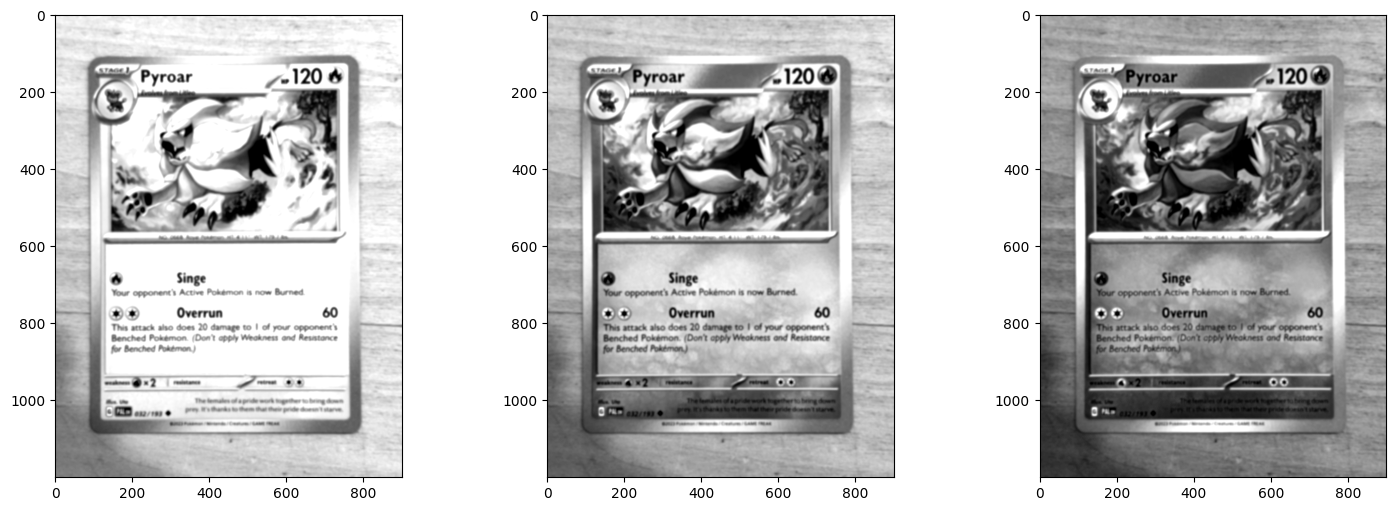

In [2123]:
draw.show_channels(np.stack([img_r, img_g, img_b], axis=2))

In [2124]:
canney_min = 50
canney_max = 150
edger = deformer.expand_edges(cv2.Canny(img_r, canney_min, canney_max))
edgeg = deformer.expand_edges(cv2.Canny(img_g, canney_min, canney_max))
edgeb = deformer.expand_edges(cv2.Canny(img_b, canney_min, canney_max))

<Figure size 1000x1000 with 0 Axes>

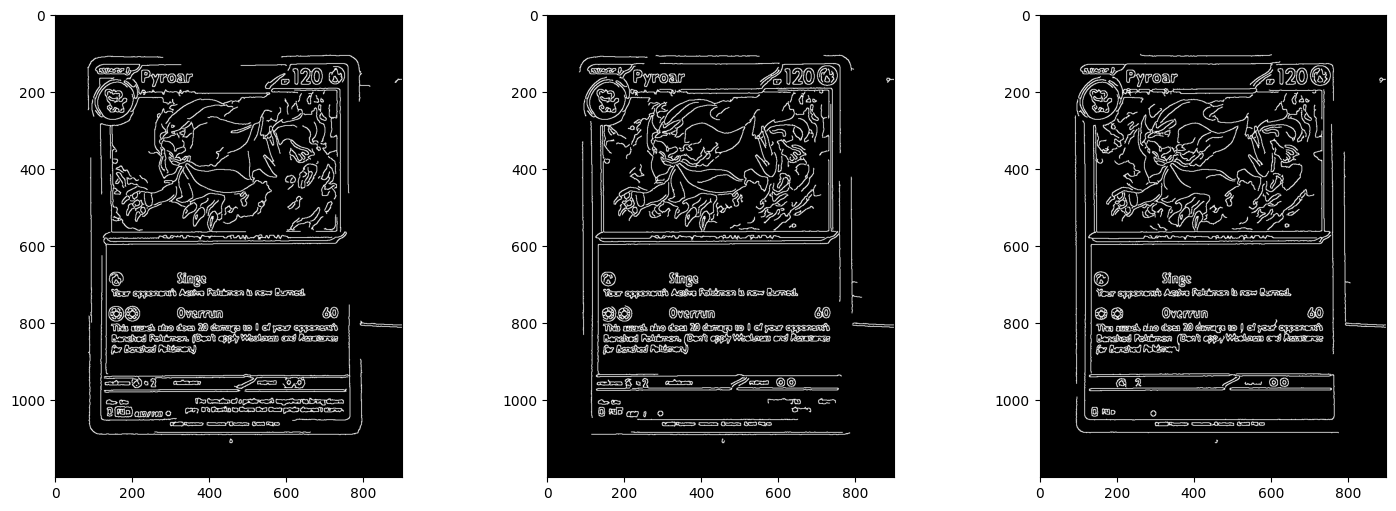

In [2125]:
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(13, 13))
draw.show_channels(np.stack([edger, edgeg, edgeb], axis=2))

In [2126]:
# img_patten = cv2.cvtColor(cv2.imread("/home/yuri/github.com/AoesJP/project_pokereader/data/card_framing3.png"), cv2.COLOR_BGR2GRAY)
# akaze = cv2.AKAZE_create()
# kp1, des1 = akaze.detectAndCompute(img_patten, None)
# kp2, des2 = akaze.detectAndCompute(edgeg, None)

In [2127]:
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# matches = bf.match(des1, des2)

# # 特徴点間のハミング距離でソート
# matches = sorted(matches, key=lambda x: x.distance)

# # 2画像間のマッチング結果画像を作成
# img1_2 = cv2.drawMatches(img_patten, kp1, edgeg, kp2, matches[:10], None, flags=2)
# plt.imshow(img1_2)

In [2128]:
# with open("/home/yuri/github.com/AoesJP/project_pokereader/data/cnt_avg_all.pickle", mode="rb") as f:
#     cnt_avg_all = pickle.load(f).astype("uint8")

# plt.imshow(cnt_avg_all)

In [2129]:
# tuple((np.array(cnt_avg_all.shape) * 0.5).astype("uint32"))

In [2130]:
# template = cv2.resize(cnt_avg_all, tuple((np.array(cnt_avg_all.shape) * 0.7).astype("uint32")))

# w, h = template.shape
# w

# result = cv2.matchTemplate(edge_mono, template, cv2.TM_CCORR_NORMED)
# # 検索結果の信頼度と位置座標の取得
# min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# top_left = max_loc

# # 検索結果の右下頂点の座標を取得
# bottom_right = (top_left[0] + w, top_left[1] + h)

# # 検索対象画像内に、検索結果を長方形で描画
# edge_mono_copy = edge_mono.copy()
# cv2.rectangle(edge_mono_copy, top_left, bottom_right, (255, 255, 0), 2)

# # 画像を表示
# plt.imshow(edge_mono_copy)

<Figure size 1000x1000 with 0 Axes>

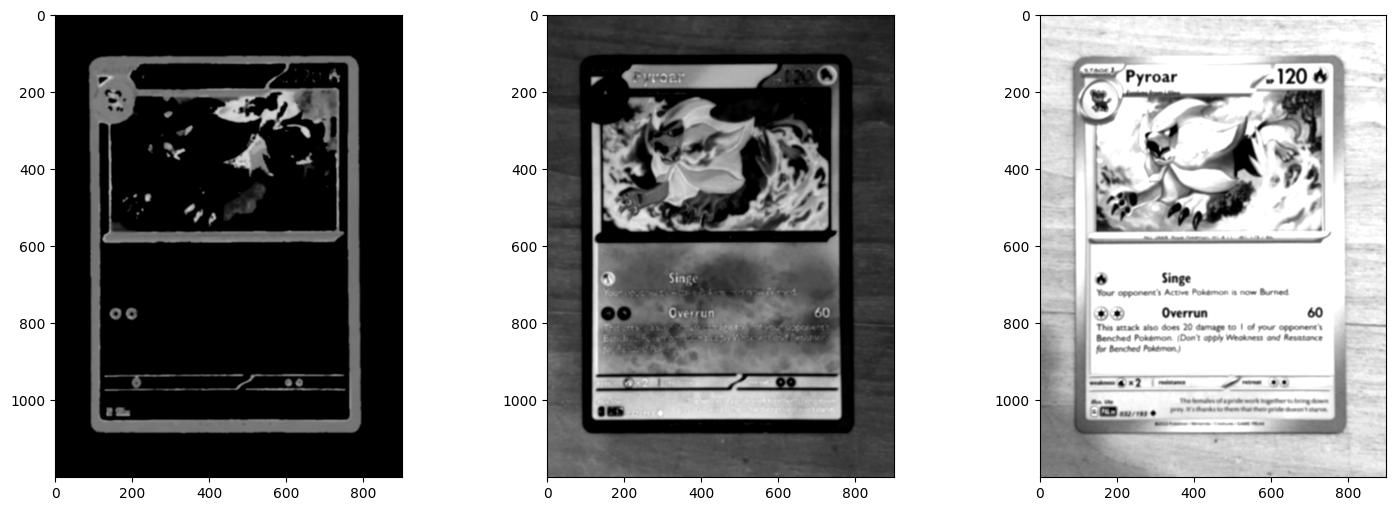

In [2131]:
draw.show_channels(np.stack([img_h, img_s, img_v], axis=2))

<Figure size 1000x1000 with 0 Axes>

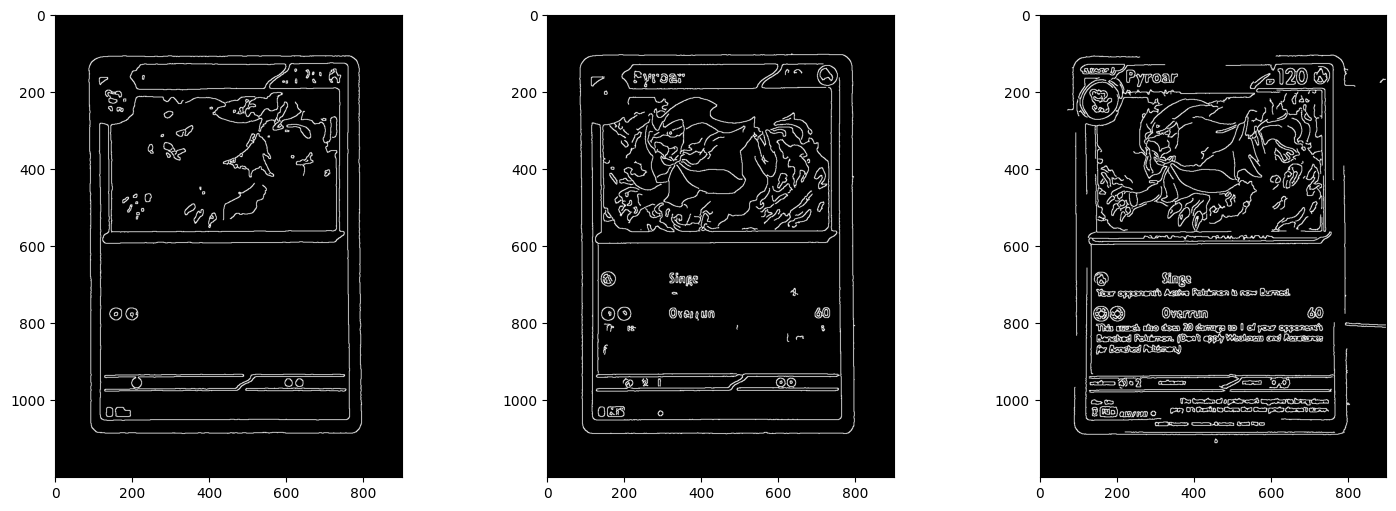

In [2132]:
draw.show_channels(np.stack([edge1, edge2, edge3], axis=2))

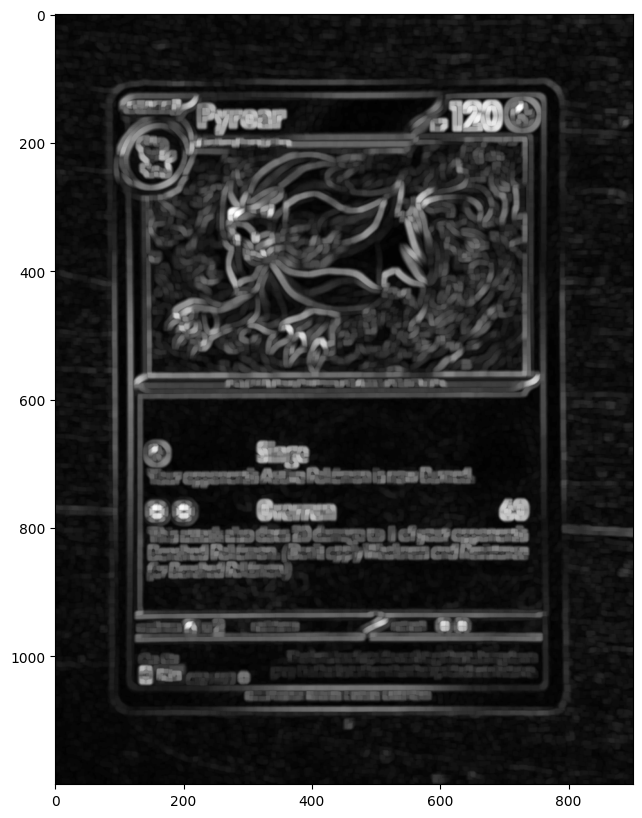

In [2133]:
plt.figure(figsize=(10, 10))
plt.imshow(deformer.expand_edges(edge_mono, kernel=(5, 5)), cmap="grey")

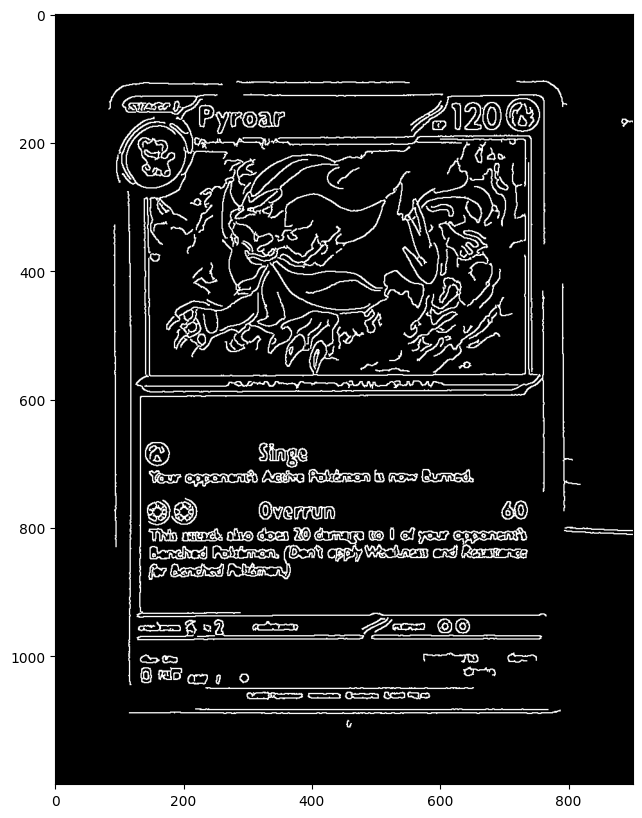

In [2134]:
plt.figure(figsize=(10, 10))
plt.imshow(edgeg, cmap="grey")

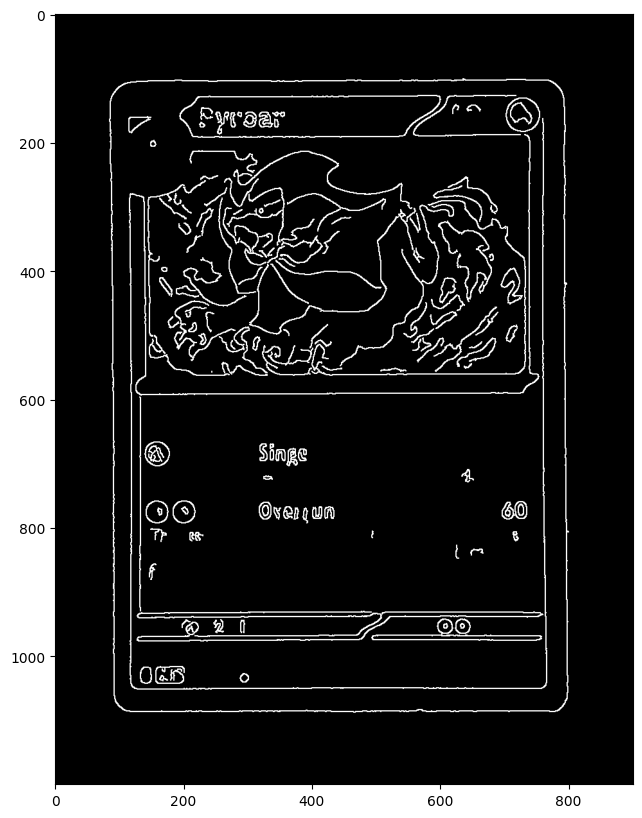

In [2135]:
plt.figure(figsize=(10, 10))
plt.imshow(edge2, cmap="grey")

In [2136]:
IMG_SIZE

(901, 1200)

In [2137]:
edger.shape, edger.dtype

((1200, 901), dtype('uint8'))

In [2138]:
edge_mono.shape, edge_mono.dtype

((1200, 901), dtype('uint8'))

In [2139]:
img.shape, img.dtype

((1200, 901, 3), dtype('uint8'))

In [2140]:
IMG_SIZE

(901, 1200)

In [2141]:
# contours, hierarchy = cv2.findContours(edge_all, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all = []
contours, hierarchy = cv2.findContours(edger, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(deformer.remove_short_long_contours(contours, IMG_SIZE, min_length=300)))
contours, hierarchy = cv2.findContours(edgeg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(deformer.remove_short_long_contours(contours, IMG_SIZE, min_length=300)))
contours, hierarchy = cv2.findContours(edgeb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(deformer.remove_short_long_contours(contours, IMG_SIZE, min_length=300)))
contours, hierarchy = cv2.findContours(edge1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(deformer.remove_short_long_contours(contours, IMG_SIZE, min_length=300)))
contours, hierarchy = cv2.findContours(edge2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(deformer.remove_short_long_contours(contours, IMG_SIZE, min_length=300)))
contours, hierarchy = cv2.findContours(edge3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(deformer.remove_short_long_contours(contours, IMG_SIZE, min_length=300)))
contours, hierarchy = cv2.findContours(edge_mono, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(deformer.remove_short_long_contours(contours, IMG_SIZE, min_length=300)))

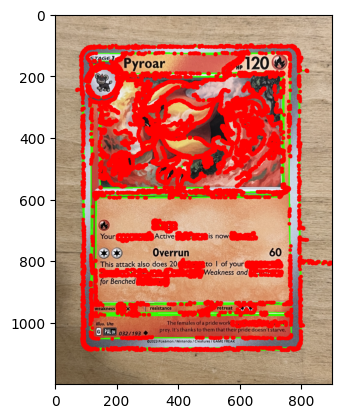

In [2142]:
draw.draw_contours(img, contours_all)

In [2143]:
cnt_smoothed = deformer.smooth_contours(contours_all)
cnt_smoothed

[array([[[ 258, 1083]],
 
        [[ 264, 1083]],
 
        [[ 265, 1084]],
 
        [[ 565, 1083]],
 
        [[ 596, 1083]],
 
        [[ 601, 1084]],
 
        [[ 607, 1083]],
 
        [[ 616, 1084]],
 
        [[ 637, 1084]],
 
        [[ 645, 1083]],
 
        [[ 650, 1083]],
 
        [[ 663, 1082]],
 
        [[ 651, 1082]],
 
        [[ 643, 1083]],
 
        [[ 609, 1083]],
 
        [[ 595, 1082]],
 
        [[ 550, 1082]],
 
        [[ 266, 1083]],
 
        [[ 265, 1082]]], dtype=int32),
 array([[[ 573,  998]],
 
        [[ 573, 1005]],
 
        [[ 574, 1006]],
 
        [[ 574, 1008]],
 
        [[ 577, 1009]],
 
        [[ 579, 1008]],
 
        [[ 588, 1010]],
 
        [[ 588, 1011]],
 
        [[ 590, 1013]],
 
        [[ 597, 1013]],
 
        [[ 601, 1009]],
 
        [[ 605, 1009]],
 
        [[ 608, 1007]],
 
        [[ 610, 1009]],
 
        [[ 614, 1009]],
 
        [[ 620, 1007]],
 
        [[ 628, 1008]],
 
        [[ 637, 1008]],
 
        [[ 637, 1006]],
 

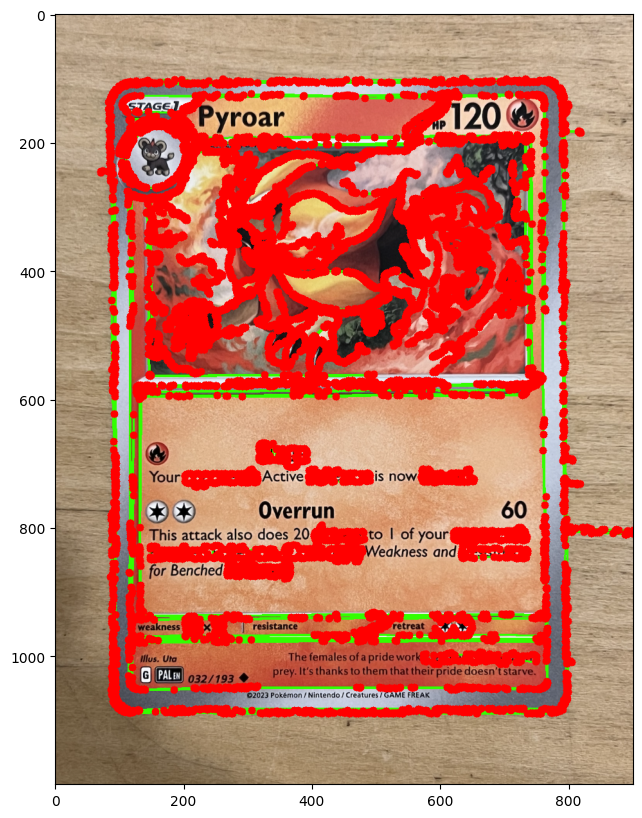

In [2144]:
plt.figure(figsize=(10, 10))
draw.draw_contours(img, cnt_smoothed)

In [2145]:
found_contours = deformer.find_rectangle_contours(cnt_smoothed, deformer.base_contour, threshold=0.3)
if not len(found_contours) > 0:
    deformer.logger.warning("No contour was found. Exiting.")
    print(cv2.resize(converted_img, output_shape))

In [2146]:
found_contours

[[array([[[ 778,  107]],
  
         [[ 775,  105]],
  
         [[ 771,  103]],
  
         [[ 768,  102]],
  
         [[ 732,  101]],
  
         [[ 702,  101]],
  
         [[ 639,  102]],
  
         [[ 636,  100]],
  
         [[ 634,  100]],
  
         [[ 633,  102]],
  
         [[ 620,  103]],
  
         [[ 592,  103]],
  
         [[ 591,  102]],
  
         [[ 476,  102]],
  
         [[ 469,  103]],
  
         [[ 467,  103]],
  
         [[ 453,  102]],
  
         [[ 383,  104]],
  
         [[ 379,  104]],
  
         [[ 373,  103]],
  
         [[ 354,  103]],
  
         [[ 350,  104]],
  
         [[ 349,  103]],
  
         [[ 345,  103]],
  
         [[ 337,  104]],
  
         [[ 239,  104]],
  
         [[ 197,  102]],
  
         [[ 186,  102]],
  
         [[ 144,  103]],
  
         [[ 126,  104]],
  
         [[ 117,  105]],
  
         [[ 112,  106]],
  
         [[ 108,  107]],
  
         [[ 104,  109]],
  
         [[  99,  112]],
  
         [[  94,  11

In [2147]:
len(found_contours)

2

In [2148]:
draw.draw_contour(img, found_contours[150][0])

IndexError: list index out of range

In [2149]:
best_fit_contour = found_contours[0][0]
best_fit_contour = deformer.reset_orientation(best_fit_contour)
# best_fit_contour_convex = cv2.convexHull(best_fit_contour)
best_fit_contour = deformer.remove_flat_points(best_fit_contour, threshold=2)

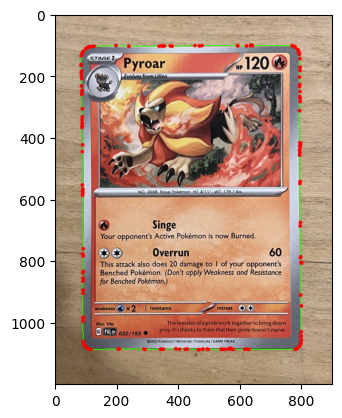

In [2150]:
draw.draw_contour(img, best_fit_contour)

In [2151]:
best_fit_contour = deformer.remove_protrude(img, best_fit_contour)

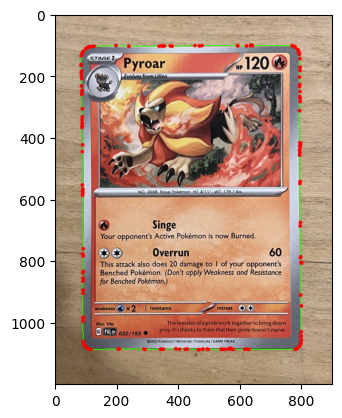

In [2152]:
draw.draw_contour(img, best_fit_contour)

In [2153]:
contour_image = np.zeros_like(img[:, :, 0])
cv2.drawContours(contour_image, [best_fit_contour], -1, (255), 1)
lines = cv2.HoughLines(contour_image, 1, np.pi / 180, 100)

In [2154]:
lines

array([[[1087.       ,    1.5707964]],

       [[ 102.       ,    1.5707964]],

       [[  90.       ,    0.       ]],

       [[ 793.       ,    0.       ]],

       [[  88.       ,    0.       ]],

       [[ -78.       ,    3.1241393]],

       [[-782.       ,    3.1241393]],

       [[ -82.       ,    3.1241393]],

       [[-786.       ,    3.1241393]],

       [[ 798.       ,    0.       ]],

       [[ 110.       ,    1.553343 ]]], dtype=float32)

In [2155]:
a = np.array([3, 2, -1, 0, -5])

In [2156]:
a.mean()

-0.2

In [2157]:
a_sign = 2 * (a >= 0).astype("int8") - 1
a * a_sign

array([3, 2, 1, 0, 5])

In [2158]:
new_lines = deformer.calc_lines(lines)

In [1874]:
new_lines

array([[-2.0791163e-01,  9.7814763e-01, -8.2200000e+02],
       [-1.9080903e-01,  9.8162717e-01, -1.8400000e+02],
       [ 9.7814763e-01,  2.0791170e-01, -2.8200000e+02],
       [ 9.7814763e-01,  2.0791170e-01, -7.4200000e+02],
       [ 9.7814763e-01,  2.0791170e-01, -2.7900000e+02],
       [ 9.7437006e-01,  2.2495104e-01, -2.9000000e+02],
       [ 9.8162717e-01,  1.9080900e-01, -7.3400000e+02],
       [-2.2495101e-01,  9.7437006e-01, -8.1500000e+02],
       [-2.0791163e-01,  9.7814763e-01, -1.7600000e+02]], dtype=float32)

In [1875]:
test_lines = np.array(new_lines[new_lines[:, 0] > 0.9])
test_lines

array([[ 9.7814763e-01,  2.0791170e-01, -2.8200000e+02],
       [ 9.7814763e-01,  2.0791170e-01, -7.4200000e+02],
       [ 9.7814763e-01,  2.0791170e-01, -2.7900000e+02],
       [ 9.7437006e-01,  2.2495104e-01, -2.9000000e+02],
       [ 9.8162717e-01,  1.9080900e-01, -7.3400000e+02]], dtype=float32)

In [1876]:
def average_line(lines: np.ndarray):
    bs = lines[:, 1]
    print(bs)
    count = bs.shape[0]
    bs_array = np.tile(bs, count).reshape((count, count))
    # print(bs_array)
    ident_mat = np.identity(count)
    flip_mat = 1 - ident_mat
    bs_array *= flip_mat
    bs_array += ident_mat
    factor = bs_array.prod(axis=1).reshape((count, 1))
    # print(factor)
    # factor = factor / np.linalg.norm(factor)
    result = np.dot(lines.T, factor).squeeze()
    result_norm = np.linalg.norm(result[:2])
    return result
    return result / result_norm

In [1877]:
avg_line = average_line(test_lines)
avg_line

[0.2079117  0.2079117  0.2079117  0.22495104 0.190809  ]


array([ 9.1001820e-03,  1.9288285e-03, -4.3988986e+00], dtype=float32)

In [1878]:
np.linalg.norm(avg_line)

4.3989086

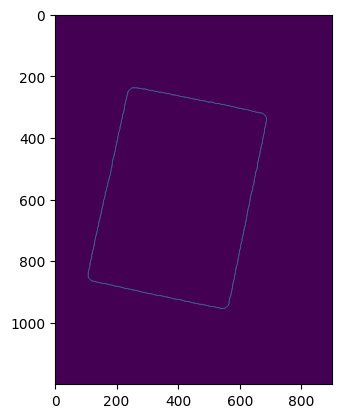

In [1879]:
contour_image = np.zeros_like(img[:, :, 0])
cv2.drawContours(contour_image, [best_fit_contour], -1, (255), 1)
plt.imshow(contour_image)

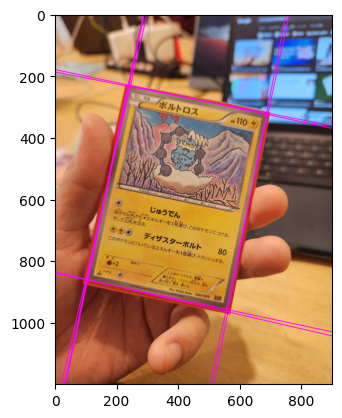

In [1880]:
draw.draw_lines(img, new_lines)

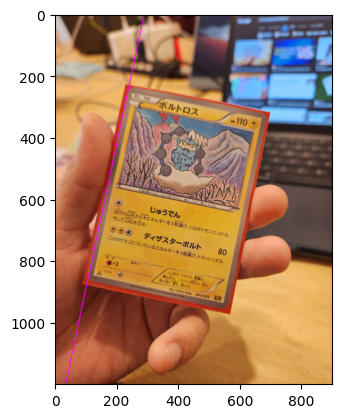

In [1881]:
draw.draw_lines(img, [test_lines[0]])

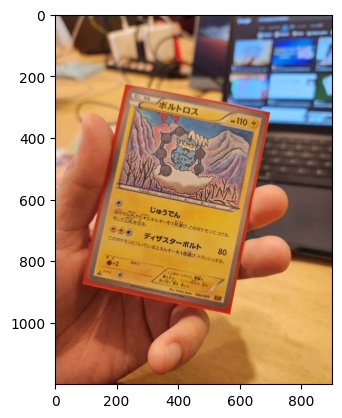

In [1882]:
draw.draw_lines(img, [avg_line])

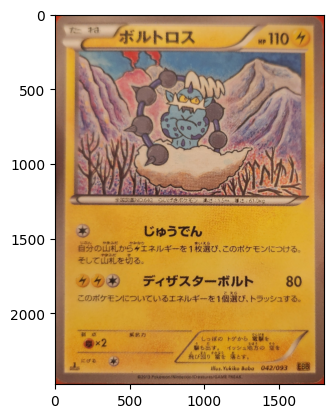

In [1883]:
pts = deformer.get_corners_from_lines(new_lines, best_fit_contour)

# best_fit_contour = get_corners_from_contour(best_fit_contour)
# best_fit_contour = reset_orientation(best_fit_contour)

plt.imshow(deformer.deform_img_to_card_from_pt(img, pts, IMG_SIZE, dst_shape=output_shape))